In [1]:
from google.colab import drive
drive.mount('/content/drive') 
#seulement si on travaille sur google drive
import os
os.chdir("/content/drive/MyDrive/formationOCR/P6")

Mounted at /content/drive


In [2]:
import pandas as pd
data = pd.read_csv(
    r"" + os.getcwd() + "/Flipkart/flipkart_com-ecommerce_sample_1050.csv"
)

In [3]:
df=data[['image','product_category_tree']]
del data
df.product_category_tree=df.product_category_tree.apply(lambda x:x.split('>>')[0][2:-1])

In [7]:
import tensorflow
tensorflow.__version__

'2.8.2'

In [5]:
path=r""+os.getcwd()+"/Flipkart/Images/"

In [4]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

In [6]:
image=load_img(path+df.image[1],target_size=(224,224))

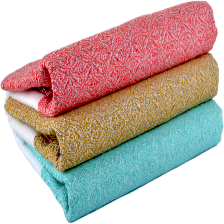

In [33]:
image

In [34]:
image = img_to_array(image)
image

array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 2

In [7]:
model = VGG16()

553476096/553467096 [==============================] - 3s 0us/step


In [8]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [8]:
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)


In [9]:
lst_vect=[]
for name_img in df.image:
  image=load_img(path+name_img,target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)
  lst_vect.append(model.predict(image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))))
  

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [12]:
import numpy as np

In [16]:
lst_v=[s[0] for s in lst_vect]

In [ ]:
lst_v

In [18]:
df_vect=pd.DataFrame(lst_v)

In [23]:
from sklearn.preprocessing import StandardScaler
scal=StandardScaler()
xscal=scal.fit_transform(df_vect)

In [25]:
from sklearn import decomposition
print("Dimensions dataset avant réduction PCA : ", xscal.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(xscal)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 850)


In [26]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df.product_category_tree
print(df_tsne.shape)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1050, 3)


In [27]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

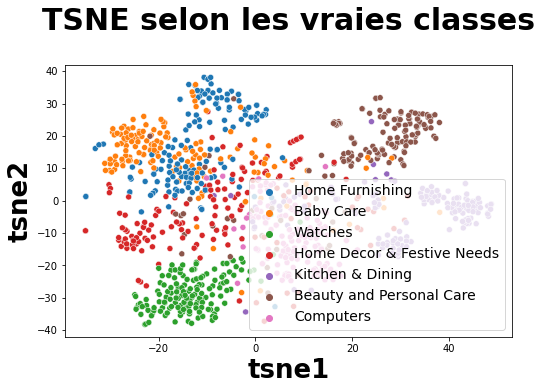

In [32]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


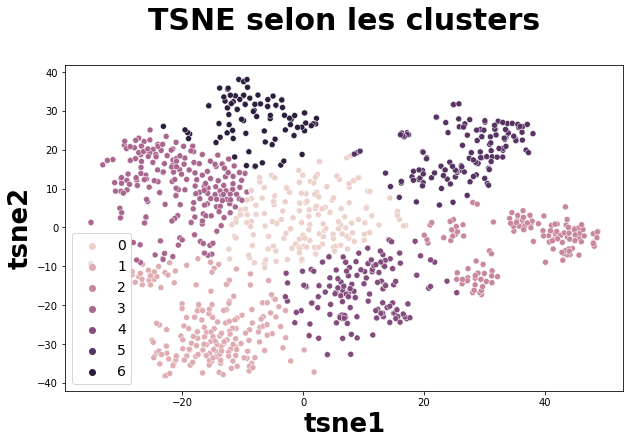

ARI :  0.45923404488278674


In [33]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df.product_category_tree
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [38]:
test=model.predict(image.reshape((1, image.shape[0], image.shape[1], image.shape[2])))

In [41]:
pd.Series(test[0])

(4096,)

In [25]:
image = preprocess_input(image)


In [26]:
image

array([[[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       ...,

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22

In [6]:
from tensorflow.keras import applications

In [7]:
dir(applications)

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'EfficientNetV2B0',
 'EfficientNetV2B1',
 'EfficientNetV2B2',
 'EfficientNetV2B3',
 'EfficientNetV2L',
 'EfficientNetV2M',
 'EfficientNetV2S',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'VGG16',
 'VGG19',
 'Xception',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'densenet',
 'efficientnet',
 'efficientnet_v2',
 'imagenet_utils',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3',
 'nasnet',
 'resnet',
 'resnet50',
 'resnet_v2',
 'vgg16',
 'vgg19',
 'xception']

In [8]:
from tensorflow.keras.applications import InceptionResNetV2

In [9]:
model=InceptionResNetV2()
model.summary()

225222656/225209952 [==============================] - 1s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)  

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [11]:
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)


In [24]:
model.input_shape[1:3]

(299, 299)

In [20]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
import numpy as np

In [25]:
  image=load_img(path+df.image[0],target_size=model.input_shape[1:3])
  image = img_to_array(image)
  image = preprocess_input(image)


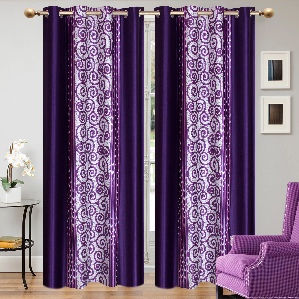

In [26]:
image

In [27]:
lst_image=[]
for name_img in df.image:
  image=load_img(path+name_img,target_size=model.input_shape[1:3])
  image = img_to_array(image)
  image = preprocess_input(image)
  lst_image.append(image)  

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [32]:
tab_img=np.array(lst_image)

In [33]:
tab_img.shape

(1050, 299, 299, 3)

In [35]:
res_extraction=model.predict(tab_img)

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [39]:
scal=StandardScaler()
xscal=scal.fit_transform(res_extraction)

In [40]:
print("Dimensions dataset avant réduction PCA : ", res_extraction.shape)
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(res_extraction)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 1536)
Dimensions dataset après réduction PCA :  (1050, 507)


In [41]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df.product_category_tree
print(df_tsne.shape)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1050, 3)


In [42]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

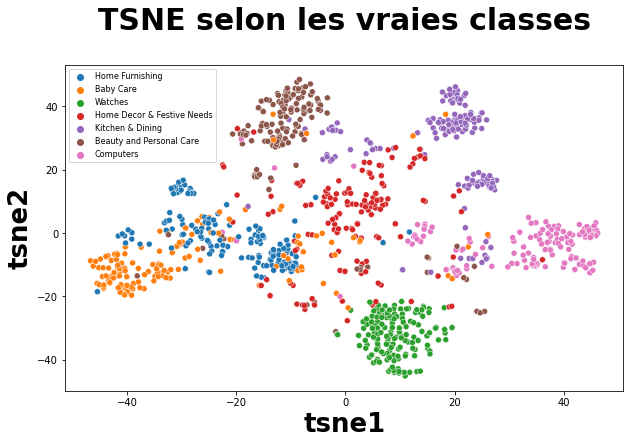

In [54]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 8}) 

plt.show()


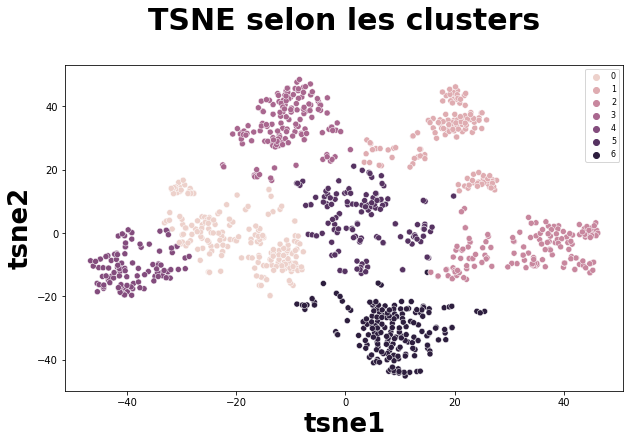

ARI :  0.5974697234800296


In [53]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 8}) 

plt.show()

labels = df.product_category_tree
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))